# Active Subspaces for Shape Optimization

__Trent Lukaczyk__, Stanford University, <twl26@stanford.edu>

__Francisco Palacios__, Stanford University

__Juan Alonso__, Stanford University, <jjalonso@stanford.edu>

__Paul Constantine__, Colorado School of Mines, <pconstan@mines.edu>

__Ryan Howard__, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces-based analysis on the ONERA-M6 wing presented in [[1]][R1].

### Introduction

The field of shape design is concerned with improving aircraft performance by altering its physical shape. Realistic shape models have dozens to hundreds of parameters, characterizing as many aspects of the shape as possible, because it is not usually known beforehand which aspects of the shape will be important. This high dimensionality drastically increases the computational cost of finding optima and increases the likelihood of finding local (rather than global) solutions. Local optimizers can be efficient, but tend to return local minima; global optimizers require many function evaluations, especially in high dimensions; and many surrogate models require additional overhead and complexity as dimensionality increases. We solve these issues with a dimension reduction technique known as _Active Subspaces_.

The Active Subspaces methodology identifies important directions in the input space (the active subspace) along which a quantity of interest changes more, on average, than in the orthogonal directions (the inactive subspace). If there is a tight trend of the output in the active subspace, this low dimensional structure can be used to identify global trends in the output, visualize the data (if the active subspace is of dimension 1 or 2), and optimization can be performed much more efficiently in this space.

### ONERA M6 Design

In this study, we are interested in the coefficients of lift ($C_L$) and drag ($C_D$) of the ONERA-M6 wing. The wing's shape is determined by 50 free-form deformation (FFD) parameters, all in the range $[-.05, .05]$. An example of this kind of deformation is shown below.

<div id="image-table">
    <table>
        <tr>
            <td style="padding:5px">
                <img src="baseline_ffdbox_original.png" style="width:300px;height:265px;">
              </td>
            <td style="padding:5px">
                <img src="baseline_ffdbox_deformed.png" style="width:300px;height:265px;">
             </td>
        </tr>
    </table>
</div>

The shape is used in solvers in the [SU2](http://su2.stanford.edu/) package, which returns to us information that can be used to calculate $C_L$, $C_D$, and their gradients with respect to the deformation parameters, which are used in finding the active subspace. An example of pressure contours produced by SU2 is presented below.

<img src="baseline_surface_flow.png" style="width:300px;height:265px;">

### Active Subspaces

Consider a scalar function $f$ ($C_L$ or $C_D$ in our case) of an $m$-dimensional vector $\mathbf x$ (the 50 FFD parameters in our case), where $\mathbf x$ is normalized to be in the hypercube $[-1, 1]^m$, with gradient $\nabla f(\mathbf x)$. Let $\rho(\mathbf x)$ be a uniform probability density on $\mathbf x$ in $[-1, 1]^m$. Active subspace analysis is based on the matrix
$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T \rho(\mathbf x)\ d\mathbf x.
$$
This can't be computed analytically in practice, so we use Monte Carlo approximation: with $\{\mathbf x_i\}_{i=1}^M$ drawn from $\rho$,
$$
\mathbf C \approx \frac{1}{M}\sum_{i=1}^M\nabla f(\mathbf x_i)\nabla f(\mathbf x_i)^T.
$$
For the ONERA-M6 wing, we approximate gradients using adjoint methods available in SU2, which are much less expensive than finite differences.

Since $\mathbf C$ is positive semidefinite, it has an eigendecomposition: $\mathbf C = \mathbf W\mathbf\Lambda\mathbf W^T$, where $\mathbf W$ contains $\mathbf C$'s eigenvectors in its columns and $\mathbf\Lambda$ is a diagonal matrix of eigenvalues (assume the eigenvalues/vectors are in descending order). We choose the dimension of our reduced space, $n$, and partition $\mathbf W$ and $\mathbf\Lambda$:

$$
\mathbf W = \left[\begin{matrix}\mathbf U & \mathbf V\end{matrix}\right],\ \mathbf\Lambda = \left[\begin{matrix}\mathbf \Lambda_1 & \\ & \mathbf \Lambda_2\end{matrix}\right],
$$

where $\mathbf U$ contains the first $n$ eigenvectors and $\mathbf\Lambda_1$ has the first $n$ eigenvalues (this is valid so long as $\lambda_n > \lambda_{n+1}$). $\mathbf U$ is a basis in the active subspace, and the active variable $\mathbf y$ is found as $\mathbf y = \mathbf U^T\mathbf x$. We can approximate $f$ in the low-dimensional active subspace as:

$$
f(\mathbf x) \approx g(\mathbf U^T\mathbf x) = g(\mathbf y) \approx \mathcal{R}(\mathbf y),
$$

where $\mathcal{R}(\mathbf y)$ is a response surface trained with the points $\{(\mathbf y_i,\ f(\mathbf x_i))\}$.

### References:

[[1]][R1] T.W. Lukaczyk, P. Constantine, F. Palacois, and J.J. Alonso. _Active Subspaces for Shape Optimization_. 10th AIAA Multidisciplinary Design Optimization Conference, AIAA SciTech, (AIAA 2014-1171) 

[[2]][R2] P.G. Constantine, E. Dow, and Q. Wang. _Active subspaces in theory and practice: applications to kriging surfaces_. SIAM J. Sci. Comput., 36(4), A1500–A1524

[[3]][R3] P.G. Constantine. _Active Subspaces: Emerging Ideas for Dimension Reduction in Parameter Studies_. SIAM, 2015. ISBN: 978-1-611973-85-3

[R1]: http://dx.doi.org/10.2514/6.2014-1171
[R2]: http://dx.doi.org/10.1137/130916138
[R3]: http://bookstore.siam.org/sl02/

### Acknowledgments

This material is based upon work supported by the U.S. Department of Energy Office of Science, Office of Advanced Scientific Computing Research, Applied Mathematics program under Award Number DE-SC-0011077.

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces)




In [1]:
import numpy as np
import pandas as pn
import active_subspaces as ac
import matplotlib.pyplot as plt
%matplotlib inline

Import the data set. Distinguish inputs (X), outputs (F), and gradients (G).

In [2]:
#Read the data from its text file
df = pn.DataFrame.from_csv('ONERA-M6.txt')
data = df.as_matrix()

#Unnoramlized input values
X = data[:,:50]

#Output values
F_lift = data[:,50]
F_drag = data[:,51]

#gradient values
G_lift = data[:,52:102]
G_drag = data[:,102:]

M, m = X.shape
labels = df.keys()
out_labels = labels[50:52]

Normalize the inputs to the interval [-1,1].

In [3]:
xl = -0.05*np.ones((1, m))
xu = 0.05*np.ones((1, m))
XX = ac.utils.misc.BoundedNormalizer(xl, xu).normalize(X)

Set up our subspaces.

In [4]:
ss_lift = ac.subspaces.Subspaces()
ss_drag = ac.subspaces.Subspaces()

ss_lift.compute(df=G_lift, nboot=500)
ss_drag.compute(df=G_drag, nboot=500)

subspaces = [ss_lift, ss_drag]

Now we plot the eigenvalues for both lift and drag.

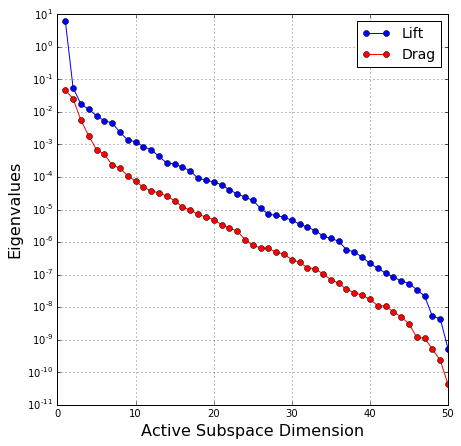

In [5]:
plt.figure(figsize=(7, 7))
plt.semilogy(range(1, 51), ss_lift.eigenvals, 'bo-')
plt.semilogy(range(1, 51), ss_drag.eigenvals, 'ro-')
plt.xlabel('Active Subspace Dimension', fontsize=16)
plt.ylabel('Eigenvalues', fontsize=16)
plt.legend(['Lift', 'Drag'], fontsize=14)
plt.grid(True)

Large gaps in eigenvalue magnitude indicate the likely presence of an active subspace. The gap between the first and second eigenvalues for lift indicates a 1-dimensional active subspace; a 2-dimensional active subspace looks more likely for drag.

<br>

Next we'll examine the $R^2$ values of quadratic radial basis response surfaces to get an idea of how tight a trend exists for active subspace dimensions up to 10.

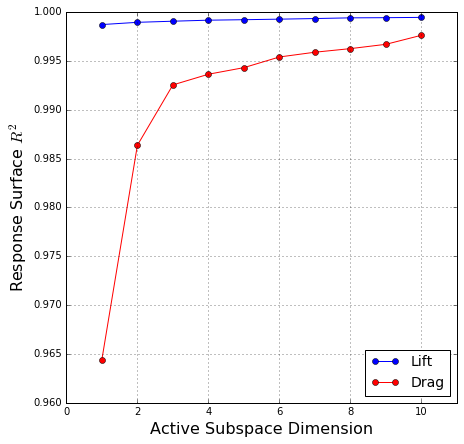

In [6]:
#array of R^2 values, 1st row = lift, 2nd row = drag
Rsqr = np.zeros((2, 10))
#Response surface object 
RS = ac.utils.response_surfaces.RadialBasisApproximation(2)

for i in range(10):
    for j in range(2):
        #Manually set subspace dimension to 1, 2, ..., 10
        subspaces[j].partition(i+1)
        #Active variable values
        y = XX.dot(subspaces[j].W1)
        F = F_lift if j is 0 else F_drag
        #Train the response surface
        RS.train(y, F[:,None])
        Rsqr[j,i] = RS.Rsqr
        
#Plot R^2 values
plt.figure(figsize=(7, 7))
x = np.arange(1, 11)
plt.plot(x, Rsqr[0], 'bo-', x, Rsqr[1], 'ro-')
plt.xlim([0, 11])
plt.grid(True)
plt.xlabel('Active Subspace Dimension', fontsize=16)
plt.ylabel(r'Response Surface $R^2$', fontsize=16)
plt.legend(['Lift', 'Drag'], loc=4, fontsize=14)

We can see that the $R^2$ values for lift start and remain very high, close to 1. The value for drag starts fairly high, around .965, and increases significantly from 1 dimension to 2 dimensions. These facts support our initial thoughts from the eigenvalue examination: the active subspace for lift is strong starting at 1 dimension while drag needs at least 2 dimensions before its performance starts to plateau.

<br>

We can visualize the data in the 1- or 2- dimensional subspaces with sufficient summary plots (plots of output vs. active variable values):

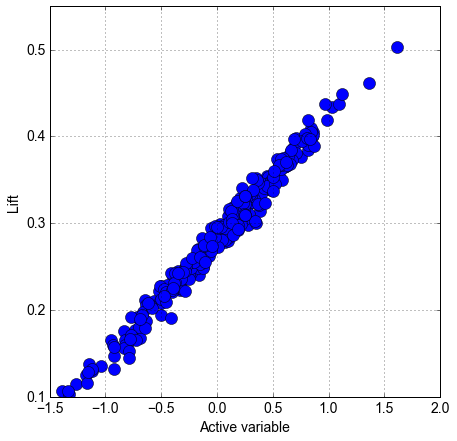

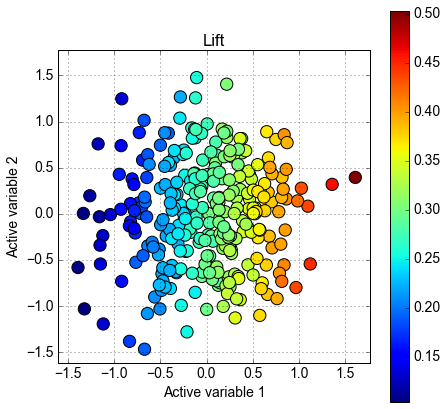

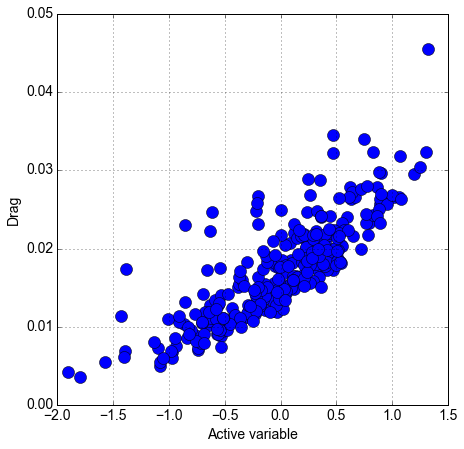

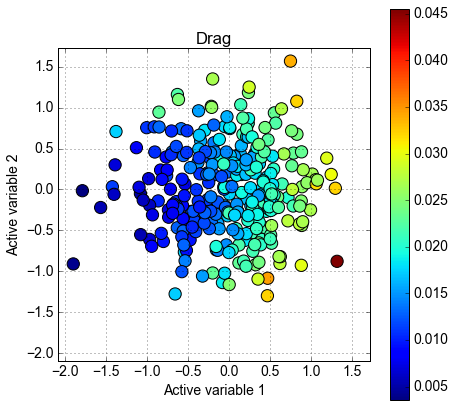

In [7]:
for j in range(2):
    subspaces[j].partition(2)
    y = XX.dot(subspaces[j].W1)
    F = F_lift if j is 0 else F_drag
    ac.utils.plotters.sufficient_summary(y, F, out_label=out_labels[j])

The strong trend is apparent for lift, as the $R^2$ value would lead us to suspect. There is a significant 1-dimensional trend for drag, but the 2-dimensional case appears more uniform, again as we would expect based on the $R^2$ analysis.

<br>

Since our input parameters are bounded, it is natural to wonder what the bounds of our active variables are. The bounds are defined by a projection of a rotated $m$-dimensional box down to the $n$-dimensional subspace. For 1 dimension, it is simply an interval whose endpoints are $\pm |\mathbf u|^T\mathbf 1$, where $\mathbf u$ is the active subspace basis, $|\cdot|$ denotes componentwise absolute value, and $\mathbf 1$ is a column vector of 1's. In higher dimensions, the projection can lead to more complex boundary geometries. We'll now show 2-dimensional summary plots with the boundaries as well.

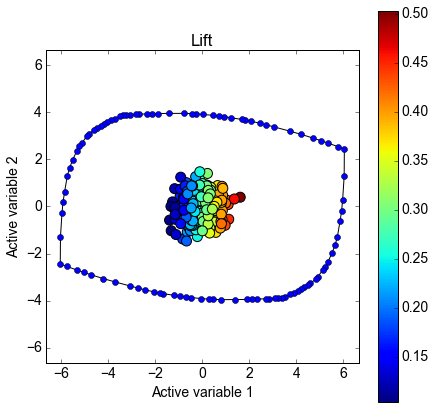

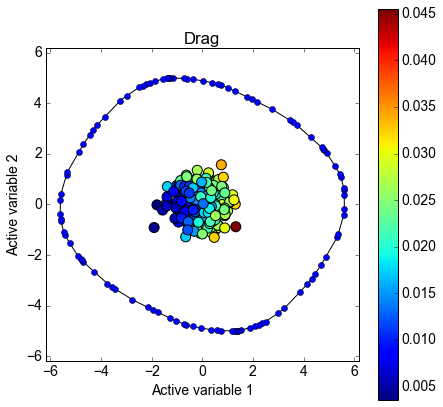

In [8]:
#These domain objects compute the vertices of the boundary
AVD_lift = ac.domains.BoundedActiveVariableDomain(ss_lift)
AVD_drag = ac.domains.BoundedActiveVariableDomain(ss_drag)

y = XX.dot(ss_lift.W1)
F = F_lift
ac.utils.plotters.zonotope_2d_plot(AVD_lift.vertY, y=y, f=F, out_label=out_labels[0])

y = XX.dot(ss_drag.W1)
F = F_drag
ac.utils.plotters.zonotope_2d_plot(AVD_drag.vertY, y=y, f=F, out_label=out_labels[1])

### Utilizing Active Subspaces

A possible use of active subspaces for the ONERA-M6 wing is constrained optimization: minimizing drag keeping lift above some threshold, for example. We would do this by finding the range of lift's active variable that keeps lift above the threshold, inverting the active variable map to the input space to find the region of the input space that satisfies our lift constraint, and finding the subset of drag's valid active variable domain corresponding to this region. When we have this region, we can use a response surface to estimate the minimum drag achievable, and map the minimizer to the input space as our solution. We could also collect more samples from the region of drag's active variable domain satisfying the lift constraint to construct a more robust response surface or use our estimated minimizer as a starting point for an optimization algorithm in the full input space, ensuring we start close to the true global minimizer. [[1]][R1] discusses these kinds of calculations in some detail and presents the specific results for the ONERA-M6. [[2]][R2] and [3] discuss in detail some other possible uses for active subspaces, such as integration, inversion, and response surface construction.

[R1]: http://dx.doi.org/10.2514/6.2014-1171
[R2]: http://dx.doi.org/10.1137/130916138